In [1]:
import gshap
import numpy as np
import pandas as pd
from gshap.datasets import load_recidivism
from gshap.intergroup import IntergroupDifference
from sklearn.model_selection import train_test_split

import random

random.seed(0)
np.random.seed(0)

INFILE = '../data/comparison.csv'

In [2]:
recidivism = load_recidivism()
X_compas, y_compas = recidivism.data, recidivism.target
X_compas = X_compas.drop(columns='high_supervision')
X_compas_train, X_compas_test, y_compas_train, y_compas_test = train_test_split(X_compas, y_compas)
X_compas.head()

,male,age,juv_fel_count,juv_misd_count,juv_other_count,priors_count,felony,black,married
0,1,31,0,0,0,0,0,0,1
1,1,21,0,1,0,1,0,1,0
2,0,21,0,0,0,0,0,1,0
3,0,30,0,0,0,0,1,1,0
4,1,32,1,1,0,20,1,0,0


In [28]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import make_pipeline, make_union
from tpot.builtins import StackingEstimator

class Model():
    def __init__(self, clf, X, exp=1):
        self.clf = clf
        self.black_idx = list(X.columns).index('black')
        self.exp = exp

    def predict_proba(self, X):
        X = X.values if isinstance(X, pd.DataFrame) else X
        black = X[:, self.black_idx]
        output = self.clf.predict_proba(X)[:,1]
        return (
            (1-black)*(2*output-output**self.exp) 
            + black*output**self.exp
        )

    def predict(self, X):
        return self.predict_proba(X) > .5

clf = make_pipeline(
    StackingEstimator(estimator=MultinomialNB(alpha=10.0, fit_prior=True)),
    StackingEstimator(estimator=MultinomialNB(alpha=0.001, fit_prior=True)),
    RandomForestClassifier(bootstrap=True, criterion="entropy", max_features=0.9500000000000001, min_samples_leaf=17, min_samples_split=11, n_estimators=100)
)
clf.fit(X_compas_train, y_compas_train)
orig_model = Model(clf, X_compas)
adj_model = Model(clf, X_compas, exp=1.14)

In [4]:
df = pd.read_csv(INFILE)
df.head()

,ParticipantID,CompletionCode,ID,EndTime,StartTime,Status,DemographicsTime,Gender,GenderSpecify,AgeBins,...,juv_other_count,priors_count,felony,black,married,output,y,FcastTimer,MostImportantFeature,next
0,test,yxI0jg,1,2020-11-19 23:43:51.969826,2020-11-19 23:32:59.155429,Completed,42.387854,Male,NaN,25-29,...,1.0,1.0,0.0,1.0,0.0,0.766923,1.0,29.173377,NaN,NaN
1,test,yxI0jg,1,2020-11-19 23:43:51.969826,2020-11-19 23:32:59.155429,Completed,42.387854,Male,NaN,25-29,...,0.0,0.0,0.0,0.0,0.0,0.088920,0.0,145.471718,NaN,NaN
2,test,yxI0jg,1,2020-11-19 23:43:51.969826,2020-11-19 23:32:59.155429,Completed,42.387854,Male,NaN,25-29,...,0.0,15.0,0.0,1.0,0.0,0.736685,1.0,8.672931,NaN,NaN
3,test,yxI0jg,1,2020-11-19 23:43:51.969826,2020-11-19 23:32:59.155429,Completed,42.387854,Male,NaN,25-29,...,0.0,1.0,1.0,1.0,0.0,0.443584,0.0,10.088882,NaN,NaN
4,test,yxI0jg,1,2020-11-19 23:43:51.969826,2020-11-19 23:32:59.155429,Completed,42.387854,Male,NaN,25-29,...,0.0,2.0,1.0,0.0,0.0,0.363658,0.0,17.196649,NaN,NaN


In [5]:
# select participants who passed comprehension checks
df = df[(df.ParticipantID!='test')]
print('N total participants', len(pd.unique(df.ParticipantID)))
df = df[(df.FcastComprehension==1) & (df.BonusComprehension==1)]
print('N passed comprehension check', len(pd.unique(df.ParticipantID)))
# select 'actual' forecasts (as opposed to practice forecasts)
df = df[df.Practice==0]
# scale forecasts to be between 0 and 1 (as opposed to 0 and 100)
df['Fcast'] = df['Fcast'] / 100.
df = df.dropna(subset=['Fcast'])
df.values.shape

N total participants 105
N passed comprehension check 84


(822, 49)

In [6]:
X = df[X_compas.columns]
y = df.Fcast
X.head()

,male,age,juv_fel_count,juv_misd_count,juv_other_count,priors_count,felony,black,married
35,0.0,42.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
36,1.0,24.0,0.0,0.0,0.0,4.0,0.0,1.0,0.0
37,1.0,34.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
38,1.0,29.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0
39,1.0,34.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [7]:
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import RandomizedSearchCV, cross_validate
from scipy.stats import expon, uniform

parameters = {
    'alpha': expon(0, 1),
    'l1_ratio': uniform(0, 1)
}

reg = RandomizedSearchCV(ElasticNet(), parameters, n_iter=2**9).fit(X, y)
res = cross_validate(reg.best_estimator_, X, y)
print(res)
res['test_score'].mean()

{'fit_time': array([0.0013659 , 0.0012033 , 0.00118947, 0.00118351, 0.00118995]), 'score_time': array([0.00083947, 0.00081253, 0.000808  , 0.00080419, 0.00081158]), 'test_score': array([0.24237016, 0.44578929, 0.23488569, 0.3486553 , 0.32682748])}


0.3197055856789278

In [8]:
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_validate
from scipy.stats import expon, uniform

parameters = {
    'eta': uniform(0, 1),
    'gamma': expon(0, 1),
    'max_depth': list(range(1, 6)),
    'min_child_weight': expon(0, 1),
    'alpha': expon(0, 1)
}
reg = RandomizedSearchCV(xgb.XGBRegressor(), parameters, n_iter=2**9).fit(X.values, y)
res = cross_validate(reg.best_estimator_, X.values, y.values)
print(res)
res['test_score'].mean()

{'fit_time': array([0.01961327, 0.01568842, 0.01560187, 0.01610112, 0.18270802]), 'score_time': array([0.00124335, 0.00126791, 0.0012207 , 0.00134516, 0.001297  ]), 'test_score': array([0.30453255, 0.59247603, 0.24190705, 0.45901269, 0.43707394])}


0.4070004517025307

In [29]:
from sklearn.metrics import accuracy_score, roc_auc_score

def fp_diff(output_white, output_black, y_white=df.y[df.black==0], y_black=df.y[df.black==1]):
    output_white = output_white[y_white==0]
    output_black = output_black[y_black==0]
    return output_black.mean() / output_white.mean() - 1

def print_metrics(output):
    print('AUC: {:.4f}'.format(roc_auc_score(df.y, output)))
    print('Accuracy: {:.4f}'.format(accuracy_score(df.y, output>.5)))
    print('Disparity: {:.4f}'.format(fp_diff(output[df.black==0], output[df.black==1])))

print('Metrics for original model')
print_metrics(orig_model.predict_proba(X))
print('\nMetrics for adjusted model')
print_metrics(adj_model.predict_proba(X))
print('\nMetrics for human prediction')
print_metrics(y)

Metrics for original model
AUC: 0.7532
Accuracy: 0.6861
Disparity: 0.3456

Metrics for adjusted model
AUC: 0.7202
Accuracy: 0.6740
Disparity: -0.2625

Metrics for human prediction
AUC: 0.6304
Accuracy: 0.6058
Disparity: 0.2540


In [10]:
output = reg.predict(X.values)
explainer = gshap.KernelExplainer(reg.predict, X.values, lambda x: x)
gshap_values = explainer.gshap_values(X.values, nsamples=1000)

In [11]:
gshap_values = gshap_values.T
gshap_values.shape

(822, 9)

In [12]:
most_import_feat_true = df.MostImportantFeature.map({col: i for i, col in enumerate(X.columns)})
most_import_feat_pred = np.argsort(-abs(gshap_values), axis=1)
isna = np.isnan(most_import_feat_true)
most_import_feat_true = most_import_feat_true[~isna]
most_import_feat_pred = most_import_feat_pred[~isna]
for i in range(most_import_feat_pred.shape[1]):
    score = accuracy_score(most_import_feat_true, most_import_feat_pred[:,i])
    print('\nPredicted importance rank: {}'.format(i+1))
    print('Accurately predicts true most important feature: {:.4f}'.format(score))


Predicted importance rank: 1
Accurately predicts true most important feature: 0.5076

Predicted importance rank: 2
Accurately predicts true most important feature: 0.2134

Predicted importance rank: 3
Accurately predicts true most important feature: 0.1023

Predicted importance rank: 4
Accurately predicts true most important feature: 0.1073

Predicted importance rank: 5
Accurately predicts true most important feature: 0.0492

Predicted importance rank: 6
Accurately predicts true most important feature: 0.0000

Predicted importance rank: 7
Accurately predicts true most important feature: 0.0000

Predicted importance rank: 8
Accurately predicts true most important feature: 0.0000

Predicted importance rank: 9
Accurately predicts true most important feature: 0.0202


In [30]:
from sklearn.metrics import r2_score

def get_gshap_values(model):
    output = model(X_compas_test.values)
    explainer = gshap.KernelExplainer(model, X_compas_train.values, lambda f_x: r2_score(output, f_x))
    gshap_values = explainer.gshap_values(X_compas_test.values, nsamples=32)
    return gshap_values / gshap_values.sum()

print('Computing GSHAP values for human mimicking model')
gshap_values_human = get_gshap_values(reg.predict)
print('Computing GSHAP values for original model')
gshap_values_orig = get_gshap_values(orig_model.predict_proba)
print('Computing GSHAP values for adjusted model')
gshap_values_adj = get_gshap_values(adj_model.predict_proba)

Computing GSHAP values for human mimicking model
Computing GSHAP values for original model
Computing GSHAP values for adjusted model


,Variables,G-SHAP,Model
5,priors_count,0.841959,Human
6,felony,0.097994,Human
1,age,0.033964,Human
7,black,0.026083,Human
0,male,0.000000,Human
8,married,0.000000,Human
1,juvenile_record,0.000000,Human
14,priors_count,0.566646,Original
10,age,0.229617,Original
2,juvenile_record,0.088643,Original


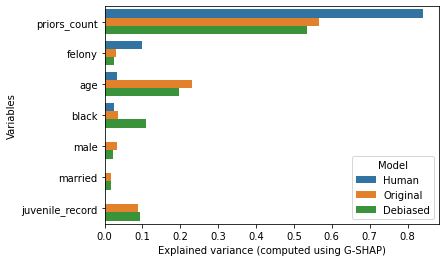

In [31]:
import seaborn as sns

def get_gshap_df(gshap_values_human, gshap_values_orig, gshap_values_adj):
    n_cols = len(X.columns)
    gshap_df = pd.DataFrame({
        'Variables': list(X.columns) * 3, 
        'G-SHAP': list(gshap_values_human) + list(gshap_values_orig) + list(gshap_values_adj),
        'Model': ['Human'] * n_cols + ['Original'] * n_cols + ['Debiased'] * n_cols
    })
    juv_offenses = ['juv_fel_count', 'juv_misd_count', 'juv_other_count']
    juv_df = gshap_df[gshap_df.Variables.isin(juv_offenses)]
    juv_df = juv_df.groupby('Model').sum().reset_index()
    juv_df['Variables'] = 'juvenile_record'
    gshap_df = gshap_df.append(juv_df)
    gshap_df = gshap_df[~gshap_df.Variables.isin(juv_offenses)]
    gshap_df['Model'] = pd.Categorical(gshap_df.Model, categories=['Human', 'Original', 'Debiased'])
    return gshap_df.sort_values(['Model', 'G-SHAP'], ascending=[True, False])

gshap_df = get_gshap_df(gshap_values_human, gshap_values_orig, gshap_values_adj)
ax = sns.barplot(y='Variables', x='G-SHAP', hue='Model', data=gshap_df)
ax.set(xlabel='Explained variance (computed using G-SHAP)')
ax.figure.savefig('figures/comparison_importance.png', bbox_inches = "tight")
gshap_df

In [15]:
from gshap.intergroup import IntergroupDifference

from functools import partial

def get_gshap_values(model):
    g = IntergroupDifference(group=X_compas_test.black, distance=fp_diff)
    explainer = gshap.KernelExplainer(model, X_compas_train.values, g)
    return explainer.gshap_values(X_compas_test.values, nsamples=128)

fp_diff = partial(
    fp_diff, 
    y_white=y_compas_test[X_compas_test.black==0],
    y_black=y_compas_test[X_compas_test.black==1]
)
print('Computing GSHAP values for human mimicking model')
gshap_values_human = get_gshap_values(reg.predict)
print('Computing GSHAP values for original model')
gshap_values_orig = get_gshap_values(orig_model.predict_proba)
print('Computing GSHAP values for adjusted model')
gshap_values_adj = get_gshap_values(adj_model.predict_proba)

Computing GSHAP values for human mimicking model
Computing GSHAP values for original model
Computing GSHAP values for adjusted model


,Variables,G-SHAP,Model
5,priors_count,0.091634,Human
7,black,0.068677,Human
6,felony,0.022569,Human
1,age,0.021826,Human
0,male,0.000000,Human
8,married,0.000000,Human
1,juvenile_record,0.000000,Human
14,priors_count,0.095250,Original
10,age,0.058297,Original
16,black,0.051897,Original


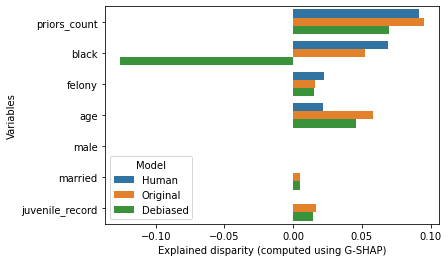

In [20]:
gshap_df = get_gshap_df(gshap_values_human, gshap_values_orig, gshap_values_adj)
ax = sns.barplot(y='Variables', x='G-SHAP', hue='Model', data=gshap_df)
ax.set(xlabel='Explained disparity (computed using G-SHAP)')
ax.figure.savefig('figures/comparison_disparity.png', bbox_inches = "tight")
gshap_df

In [17]:
gshap_df.groupby('Model').sum()

,Explained disparity
Model,
Human,0.204705
Original,0.242714
Debiased,0.023166
